# Железничар Калман

### Краток опис

Во оваа дигитална тетратка е прикажан пример за робот кој се движи по шини кои се поврзани кружно. Примерот служи за објаснување на основните концепти кај Калмановиот филтер.

In [1]:
from dataclasses import dataclass
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import plotly.offline as off
import plotly.graph_objs as go

Преку класата `Gaussian` е моделирано верувањето за позицијата на роботот како нормална распределба.

In [2]:
@dataclass
class Gaussian:
    position: float
    variance: float
    
    def __add__(self, other):
        return Gaussian((self.position + other.position) % 10, self.variance + other.variance)
    
    def __mul__(self, other):
        variance_sum = self.variance + other.variance
        if self.position - other.position > 5:
            self.position -= 10
        elif other.position - self.position > 5:
            other.position -= 10
        new_position = (self.position * other.variance + other.position * self.variance) / variance_sum
        new_position %= 10
        new_variance = self.variance * other.variance / variance_sum
        return Gaussian(new_position, new_variance)
    
    def evaluate(self, x):
        return np.exp(-np.power(x - self.position, 2.) / (2 * self.variance)) / np.sqrt(2 * np.pi * np.sqrt(self.variance))
    
    def evaluate2(self, x):
        y = self.evaluate(x)
        if self.position - 3*np.sqrt(self.variance) < 0:
            y += self.evaluate(np.arange(-10, 0, 0.01))
        if self.position + 3*np.sqrt(self.variance) > 10:
            y += self.evaluate(np.arange(10, 20, 0.01))
        return y


Во класата `Railman` е вметната физиката на движењето и мерењето податоци кај нашиот робот кој се движи по кружна патека.

In [3]:
class Railman():
    def __init__(self, track_len):
        self.track_len = track_len
        self.position = 0

    def move(self, distance=1, process_noise=.1):
        self.position += np.random.normal(distance, process_noise)
        self.position %= self.track_len
        return self.position
    
    def sense(self, measurment_noise):
        return np.random.normal(self.position, measurment_noise) % 10

Да почнеме со симулација на движењето на роботот по патеката. За разлика од претходниот пример со Баесовиот филтер, тука не ја делиме патеката на 10 сегменти. Едноставно, позицијата на роботот е претставена преку реален број. Еве краток пример за движењето на роботот за 10 чекори. Придвижувањето на роботот го симулираме преку додавање на случајна вредност добиена од нормална распределба со средна вредност еднаква на еден чекор и со варијанса еднаква на моделираната вредност со која роботот отстапува од точно еден чекор. Оваа функција е имплементирана во функцијата `move()` од класата `Railman`.

In [7]:
robot = Railman(10)
robot_history = []
for _ in range(10):
    robot.move(distance=1, process_noise=.2)
    robot_history.append(robot.position)

data = [go.Scatter(y=robot_history)]
off.iplot({'data': data, 'layout': {'title': 'Позиција на роботот на шините при постојано движење нанапред',
                                    'xaxis': {'title': 'Чекори'},
                                    'yaxis': {'title': 'Позиција'}}})

На следниот график е прикажано верувањето кое го имаме ние за вистинската позиција на роботот. Во овој случај тоа е позиција 1 со варијанса 0.01.

In [12]:
belief = Gaussian(1, 0.01)
x = np.arange(0, 10, 0.01)
y = belief.evaluate2(x)
data = [go.Scatter(x=x, y=y)]
off.iplot({'data': data, 'layout': {'title': 'Распределба на веројатноста за позицијата на роботот',
                                    'xaxis': {'title': 'Позиција'},
                                    'yaxis': {'title': 'Верoјатност'}}})

За секој нареден чекор нашето верување се намалува, а кај Баесовиот филтер оваа операција ја добивавме преку конволуција на моменталното верување со информацијата за направен нов чекор. Во овој случај почнуваме од позиција 1, моменталното верување ни е нормална распределба, и правиме чекори без да добиваме информација за позицијата од некој сензор. За секој направен чекор треба оваа распределба да ја конволуираме со нормална распределба каде варијансата го изразува отстапувањето кое може да го направи роботот при правење на еден чекор. При конволуција на тие две распределби добиваме нова распределба која исто така е нормална. Доказот е прикажан [тука](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables), а крајниот резултат вели:

$$
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
$$

Ова е веќе имплементирано во кодот преку преоптоварување на `+` операторот кај класата `Gaussian`.

На ваков начин правиме 10 чекори, а на крај кога ќе се вратиме на истата позиција, во 1, приметуваме за колку всушност нашето верување се намалило вртејќи еден круг.

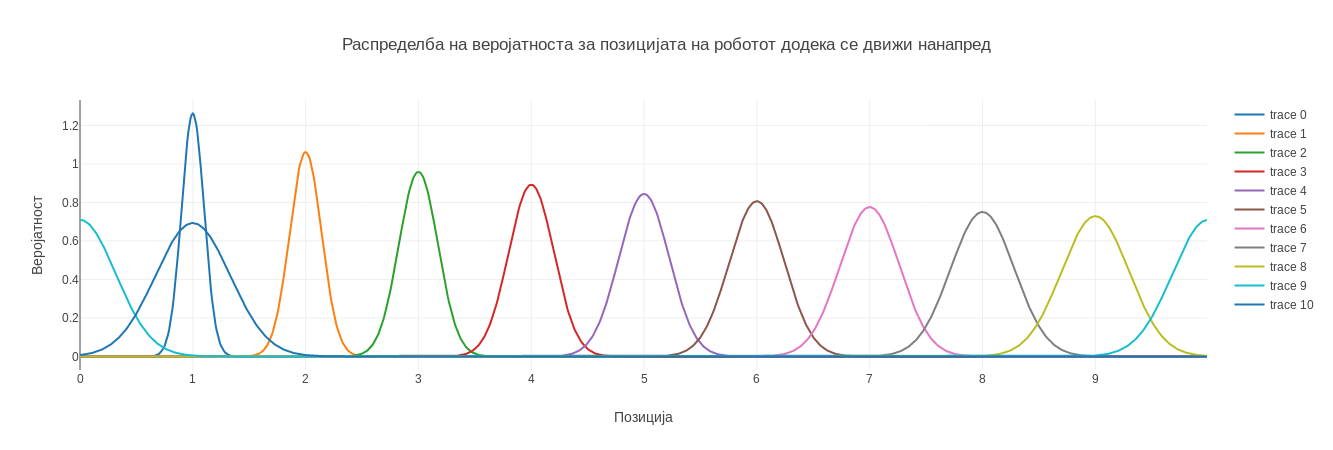

In [13]:
for _ in range(10):
    belief += Gaussian(1, .01)
    x = np.arange(0, 10, 0.01)
    y = belief.evaluate2(x)
    data.append(go.Scatter(x=x, y=y))
off.iplot({'data': data, 'layout': {'title': 'Распределба на веројатноста за позицијата на роботот додека се движи нанапред',
                                    'xaxis': {'title': 'Позиција'},
                                    'yaxis': {'title': 'Верoјатност'}}})

Кога ќе добиеме мерење потребно е таа информација да ја искористиме за да го подобриме нашето верување. Да претпоставиме дека имаме поставено само еден сензор кој ќе ни ја даде позицијата на роботот, но со некој шум, како што е моделирано во функцијата `sense()` во класата `Railman`. Кај Баесовиот филтер користевме множење на верувањето со мерењето, па и тука оваа операција може да се постигне преку множење на нашето моментално верување со информацијата за мерењето, а резултатот е нова нормална распределба која ни го дава ажурирано верувањето за позицијата на роботот. Каков и да е сензорот, информацијата која тој ќе ја даде на неговиот излез треба да се претстави преку нормална распределба. Тоа лесно ќе го направиме преку создавање на нормална распределба со средна вредност еднаква на новоизмерената вредност и варијанса еднаква на шумот на сензорот. Доколку ги помножиме двете нормални распределби ќе дојдеме до равенките

$$
\mu = \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

$$
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
$$

Доказот може да го видите [тука](http://www.tina-vision.net/docs/memos/2003-003.pdf).
Ова е веќе имплементирано во кодот преку преоптоварување на `*` операторот кај класата `Gaussian`.

На следниот график прикажано е нашето моментално верување, мерењето и обновеното верување како производ од дадените нормални распределби. Забележете дека обновеното верување секогаш ќе има помала варијанса од претходното верување бидејќи секое ново мерење придонесува во проценувањето на вистинската положба на роботот. Слободно менувајте ги распределбите за верувањето и мерењето за да стекнете чувство како се ажурира позицијата на роботот. 

In [19]:
prior = Gaussian(3, .5)
measurement = Gaussian(7, 1.5)
belief = prior * measurement
x = np.arange(0, 10, 0.01)
data = [go.Scatter(x=x, y=prior.evaluate(x), name='Верување'), 
        go.Scatter(x=x, y=measurement.evaluate(x), name='Мерење'), 
        go.Scatter(x=x, y=belief.evaluate(x), name='Обновено верување')]
off.iplot({'data': data, 'layout': {'title': 'Распределба на веројатноста за позицијата на роботот',
                                    'xaxis': {'title': 'Позиција'},
                                    'yaxis': {'title': 'Верoјатност'}}})

Понатаму, ќе направиме симулација на Калмановиот филтер следејќи ги стандардните чекори. Почнуваме со верување кое има голема варијанса за да ознаничиме дека врска немаме каде навистина се наоѓа роботот.
1. Правиме чекор со роботот
* Правиме предвидување на позицијата на роботот
* Земаме информации од сензорите
* Ги спојуваме предвидувањето и информацијата од сензорите за да добиеме ново верување

Резултатите се прикажани во форма на слика за секоја итерација. Слободно симулирајте со различни вредности на шумот на сензорите `measurement_noise` или шумот кој го имаме при движење на роботот `process_noise`. Во дадениот пример почнуваме со погрешна почетна претпоставска за позицијата на роботот.

Вистинската позиција е: 1.0356026171664712
Предвидување Gaussian(position=6, variance=0.31)


Мерење Gaussian(position=1.119337879312139, variance=0.5)
Gaussian(position=1.119337879312139, variance=0.5)


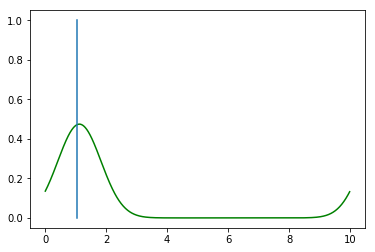

Верување Gaussian(position=4.132092274798473, variance=0.19135802469135801)
Gaussian(position=4.132092274798473, variance=0.19135802469135801)


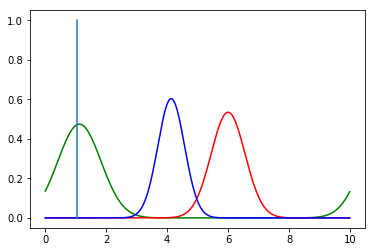

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 1.9563506097153753
Предвидување Gaussian(position=5.132092274798473, variance=0.49135802469135803)


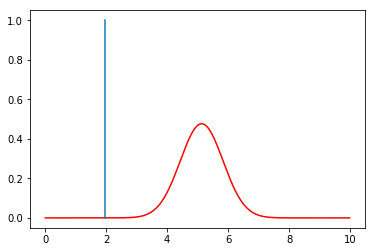

Мерење Gaussian(position=1.4631002848193013, variance=0.5)
Gaussian(position=1.4631002848193013, variance=0.5)


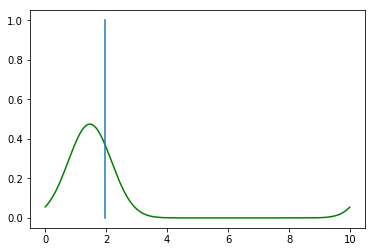

Верување Gaussian(position=3.313588150250889, variance=0.24782067247820672)
Gaussian(position=3.313588150250889, variance=0.24782067247820672)


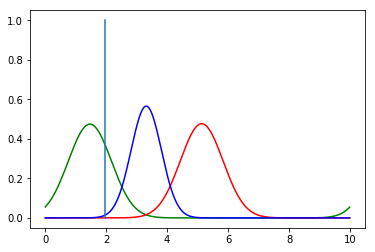

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 2.980339227553377
Предвидување Gaussian(position=4.313588150250888, variance=0.5478206724782066)


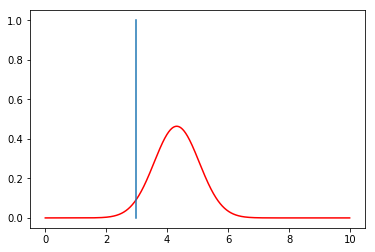

Мерење Gaussian(position=3.214729035438554, variance=0.5)
Gaussian(position=3.214729035438554, variance=0.5)


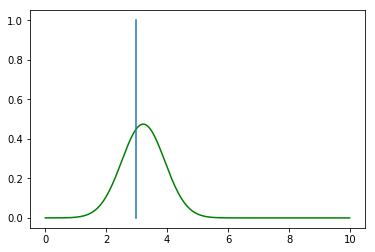

Верување Gaussian(position=3.739083604724449, variance=0.26140955550273354)
Gaussian(position=3.739083604724449, variance=0.26140955550273354)


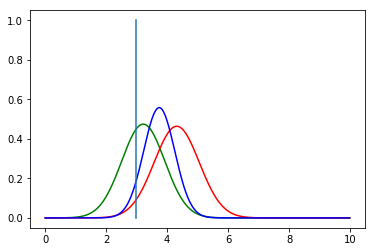

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 3.91650224802586
Предвидување Gaussian(position=4.739083604724449, variance=0.5614095555027335)


Мерење Gaussian(position=3.418485514926223, variance=0.5)
Gaussian(position=3.418485514926223, variance=0.5)


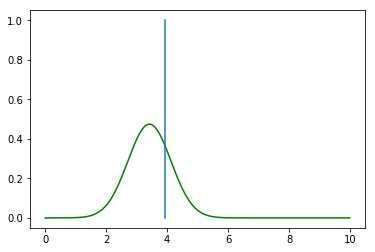

Верување Gaussian(position=4.040581897492107, variance=0.26446415174622373)
Gaussian(position=4.040581897492107, variance=0.26446415174622373)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 4.942685746388453
Предвидување Gaussian(position=5.040581897492107, variance=0.5644641517462237)


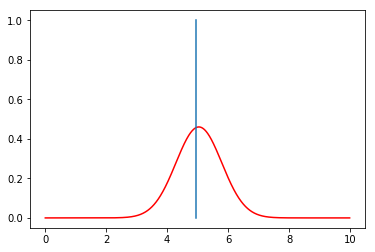

Мерење Gaussian(position=4.53824460638172, variance=0.5)
Gaussian(position=4.53824460638172, variance=0.5)


Верување Gaussian(position=4.774202430929553, variance=0.26514004760998106)
Gaussian(position=4.774202430929553, variance=0.26514004760998106)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 5.875874391990767
Предвидување Gaussian(position=5.774202430929553, variance=0.565140047609981)


Мерење Gaussian(position=6.228219542437885, variance=0.5)
Gaussian(position=6.228219542437885, variance=0.5)


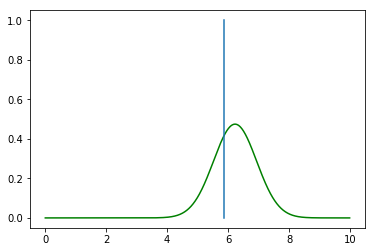

Верување Gaussian(position=6.015093994991294, variance=0.2652890804725974)
Gaussian(position=6.015093994991294, variance=0.2652890804725974)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 6.784582986830516
Предвидување Gaussian(position=7.015093994991294, variance=0.5652890804725974)


Мерење Gaussian(position=7.2697473313836785, variance=0.5)
Gaussian(position=7.2697473313836785, variance=0.5)


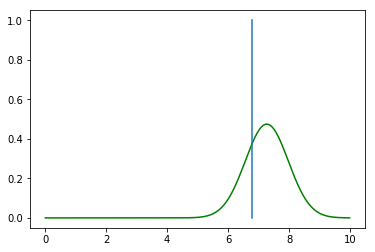

Верување Gaussian(position=7.150224217395028, variance=0.2653219162923441)
Gaussian(position=7.150224217395028, variance=0.2653219162923441)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 7.710080723577539
Предвидување Gaussian(position=8.150224217395028, variance=0.5653219162923441)


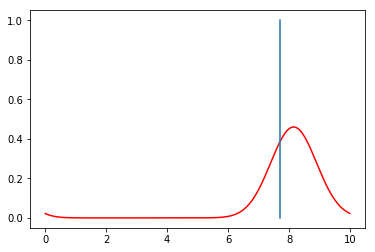

Мерење Gaussian(position=7.692485407139076, variance=0.5)
Gaussian(position=7.692485407139076, variance=0.5)


Верување Gaussian(position=7.907321318827172, variance=0.2653291496432564)
Gaussian(position=7.907321318827172, variance=0.2653291496432564)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 8.623564541624877
Предвидување Gaussian(position=8.907321318827172, variance=0.5653291496432564)


Мерење Gaussian(position=8.866165843364314, variance=0.5)
Gaussian(position=8.866165843364314, variance=0.5)


Верување Gaussian(position=8.885481693060457, variance=0.2653307430067818)
Gaussian(position=8.885481693060457, variance=0.2653307430067818)


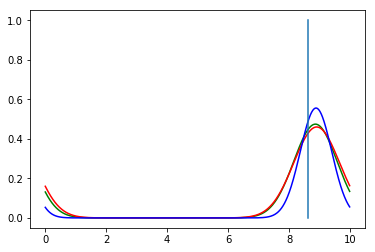

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 9.68622017881051
Предвидување Gaussian(position=9.885481693060457, variance=0.5653307430067818)


Мерење Gaussian(position=0.5062851682712441, variance=0.5)
Gaussian(position=0.5062851682712441, variance=0.5)


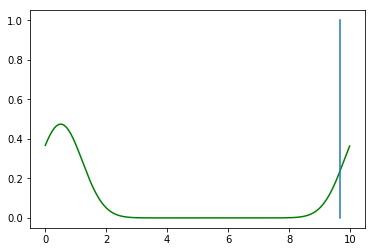

Верување Gaussian(position=0.21491862352165983, variance=0.2653310939902083)
Gaussian(position=0.21491862352165983, variance=0.2653310939902083)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 0.6076797506944516
Предвидување Gaussian(position=1.2149186235216598, variance=0.5653310939902083)


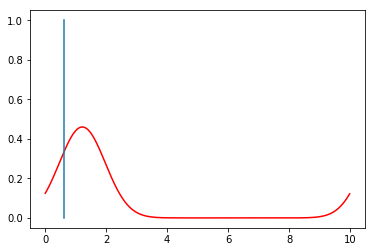

Мерење Gaussian(position=1.17965549723292, variance=0.5)
Gaussian(position=1.17965549723292, variance=0.5)


Верување Gaussian(position=1.1962058103175883, variance=0.2653311713041037)
Gaussian(position=1.1962058103175883, variance=0.2653311713041037)


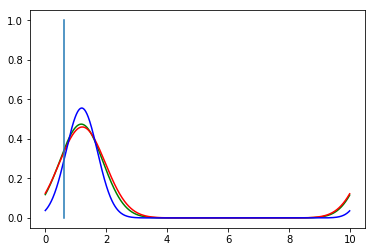

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 1.5166691227409677
Предвидување Gaussian(position=2.196205810317588, variance=0.5653311713041037)


Мерење Gaussian(position=1.8621797022025666, variance=0.5)
Gaussian(position=1.8621797022025666, variance=0.5)


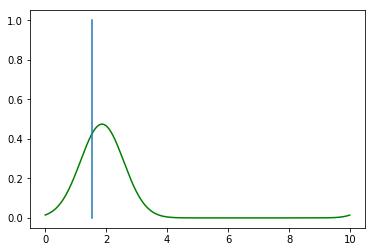

Верување Gaussian(position=2.018950721915681, variance=0.26533118833464003)
Gaussian(position=2.018950721915681, variance=0.26533118833464003)


-------------------------------------------------------------------------------------------------
Вистинската позиција е: 2.514826597268001
Предвидување Gaussian(position=3.018950721915681, variance=0.56533118833464)


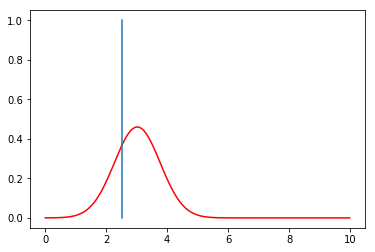

Мерење Gaussian(position=1.7317239273860023, variance=0.5)
Gaussian(position=1.7317239273860023, variance=0.5)


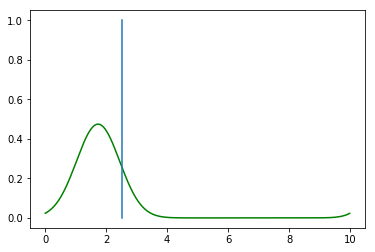

Верување Gaussian(position=2.335867882160251, variance=0.2653311920860892)
Gaussian(position=2.335867882160251, variance=0.2653311920860892)


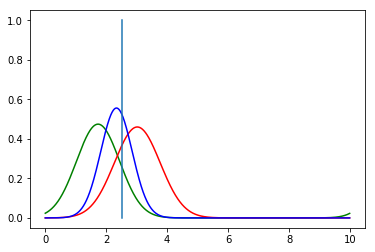

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 3.5359662906112925
Предвидување Gaussian(position=3.335867882160251, variance=0.5653311920860892)


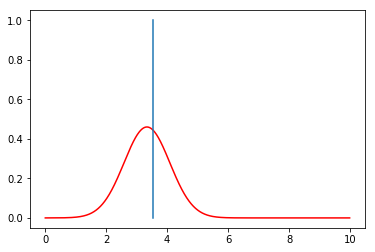

Мерење Gaussian(position=3.8584541865360196, variance=0.5)
Gaussian(position=3.8584541865360196, variance=0.5)


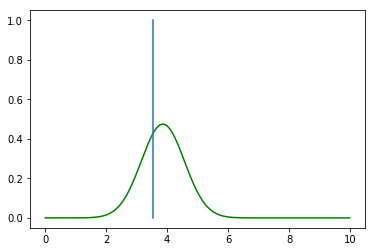

Верување Gaussian(position=3.6131847772397134, variance=0.2653311929124501)
Gaussian(position=3.6131847772397134, variance=0.2653311929124501)


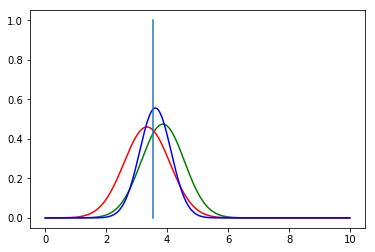

-------------------------------------------------------------------------------------------------
Вистинската позиција е: 4.632815089394073
Предвидување Gaussian(position=4.613184777239713, variance=0.56533119291245)


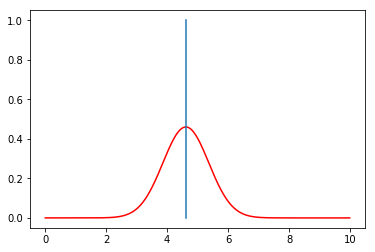

Мерење Gaussian(position=4.873688249824297, variance=0.5)
Gaussian(position=4.873688249824297, variance=0.5)


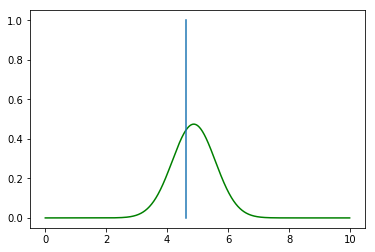

Верување Gaussian(position=4.751424171611958, variance=0.26533119309447906)
Gaussian(position=4.751424171611958, variance=0.26533119309447906)


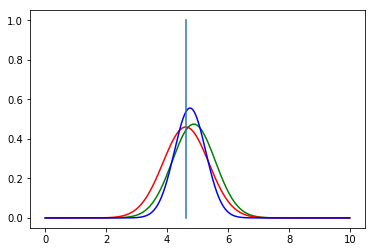

-------------------------------------------------------------------------------------------------


In [27]:
belief = Gaussian(5, 0.01)
r = Railman(10)
for i in range(15):
    x = np.arange(0, 10, .01)
    u = 1
    process_noise = .3
    measurement_noise = .5
    
    r.move(u)
    print('Вистинската позиција е: {}'.format(r.position))
    
    prediction = belief + Gaussian(u, process_noise)
    print('Предвидување', prediction)
    plt.plot(x, prediction.evaluate2(x), color='r')
    plt.plot([r.position, r.position], [0, 1])
    plt.show()
    
    measurement = Gaussian(r.sense(measurement_noise), measurement_noise)
    print('Мерење', measurement)
    print(measurement)
    plt.plot(x, measurement.evaluate2(x), color='g')
    plt.plot([r.position, r.position], [0, 1])
    plt.show()
    
    belief = prediction * measurement
    print('Верување', belief)
    print(belief)
    plt.plot(x, measurement.evaluate2(x), color='g')
    plt.plot(x, prediction.evaluate2(x), color='r')
    plt.plot(x, belief.evaluate2(x), color='b')
    plt.plot([r.position, r.position], [0, 1])
    plt.show()
    print('-------------------------------------------------------------------------------------------------')

Ова е пример за Калманов филтер во 1 димензија. Неговата примена во светот е ограничена поради линеарноста на системот врз кој е заснован филтерот. Во наредните тетратки ќе работиме со Калманов филтер за повеќе димензии, па ќе направиме обопштување кое ќе нѐ одведе до обопштените равенки за Калмановиот филтер кои можат да се сретнат насекаде низ литературата.